### Plot data

In [5]:
import numpy as np
from matplotlib import pyplot as plt

In [6]:
mol_ae_global = np.loadtxt('/home/misa/APDFT/prototyping/atomic_energies/results/analyse_learning/reference/l_curve_global_global.tab')

mol_ae_global2 = np.loadtxt('/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/learning_curve_global_label.txt')

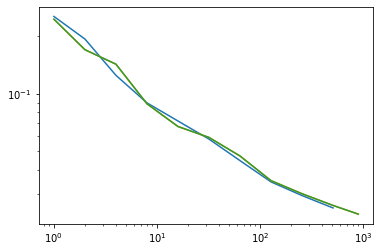

In [7]:
plt.plot(mol_ae_global[:,0], mol_ae_global[:,1])
plt.plot(mol_ae_global2[:,0], mol_ae_global2[:,1])
plt.plot(lcurve[:,0], lcurve[:,1])

plt.xscale('log')
plt.yscale('log')

### Make clean learning curve with optimized hyperparameters

In [1]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

from utils_qm import save_obj, load_obj

In [2]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())

global_reps = qmi.wrapper_global_representations(data, molecule_size) # all global representations

global_labels = np.zeros(len(global_reps)) # all global labels
for idx, mol in enumerate(data):
    global_labels[idx] = data[idx][:,6].sum()

In [3]:
opt_sigma = 222.8609442038079
lam_val = 1e-4
num_cv = 10

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 9, 10, base=2).astype(int)
set_sizes = np.concatenate((set_sizes, np.array([900])))

error_cv = []
error_std = []
# calculate error for every training point size
for idx, tr_size in enumerate(set_sizes):
    err, err_std = qmi.crossvalidate(global_reps, global_labels, tr_size, opt_sigma, lam_val, num_cv)
    error_cv.append(err)
    error_std.append(err_std)
    
lcurve = np.array([set_sizes, error_cv, error_std]).T

In [4]:
# filename
path = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/learning_curve_global_label.txt'

sig_val = opt_sigma
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, lcurve, delimiter='\t', header=header)

### Hyperparameter Optimization

In [ ]:
import numpy as np
import qml
import sys
sys.path.insert(0, '/home/misa/git_repositories/APDFT/prototyping/atomic_energies/')
import qml_interface as qmi
import sklearn.model_selection as sk
import pickle

from utils_qm import save_obj

In [ ]:
# data preparation
data, molecule_size = qmi.load_alchemy_data(qmi.wrapper_alch_data())

global_reps = qmi.wrapper_global_representations(data, molecule_size) # all global representations

global_labels = np.zeros(len(global_reps)) # all global labels
for idx, mol in enumerate(data):
    global_labels[idx] = data[idx][:,6].sum()

In [ ]:
sigmas = np.logspace(-1, 10, 11, base=2)
lam_val = 1e-5
num_cv = 3

lcurves = dict()

# define number of training points for which MAE is calculated
set_sizes = np.logspace(0, 9, 10, base=2).astype(int)
set_sizes = np.concatenate((set_sizes, np.array([900])))

for sigma in sigmas:
    error_cv = []
    error_std = []
    # calculate error for every training point size
    for idx, tr_size in enumerate(set_sizes):
        err, err_std = qmi.crossvalidate(global_reps, global_labels, tr_size, sigma, lam_val, num_cv)
        error_cv.append(err)
        error_std.append(err_std)
    
    lcurves[f'sig_{sigma}'] = np.array([set_sizes, error_cv, error_std]).T

In [ ]:
# save best learning curve
lowest_error = (None, None)
for k in lcurves.keys():
    if lowest_error[1]==None or lowest_error[1] > np.amin(lcurves[k][:,1]):
        lowest_error = (k, np.amin(lcurves[k][:,1]))
save_data = lcurves[lowest_error[0]]

# filename
path = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/best_atomisation_global_label.txt'

sig_val = lowest_error[0].split('_')[1]
header = f'sigma = {sig_val}, lambda = {lam_val}, number cv = {num_cv}'
np.savetxt(path, save_data, delimiter='\t', header=header)

# save dictionary of learning curves at all sigmas
fname = '/home/misa/projects/Atomic-Energies/data/lcurves/lcurves_atomisation/all_sigma_atomisation_global_label.txt'
save_obj(lcurves, fname)